# Modelling and Evaluation

**Make sure that you have run data_collection.ipynb before running this one.**

## Objectives

- To address business requirement 2:
  - The client wants to know if a given image of a cherry leaf is healthy or shows powdery mildew.

## Inputs

This notebook will use the following inputs:

- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation
- outputs/v1/image_shape.pkl

## Outputs

This notebook will generate the following outputs:

- Plot showing the number of images in the train, validation, and test sets.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Saved model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import pickle
import tensorflow
from matplotlib.image import imread
from PIL import Image


## Change working directory

By default, the working directory is "jupyter_notebooks", where the notebook is running. However, we need to change the working directory to its parent folder so that file references align with the broader project structure.

To do this, we first check the current working directory — note that the output below only displays the last two folders in the file path, rather than the full system path. This is done intentionally to prevent exposing the full local file path stored on my machine.

**Any time you revisit this notebook after logging out, or open a different notebook for the first time, you must repeat these steps to ensure the working directory is always correctly set.**

In [2]:
from pathlib import Path # ensure file path consistency

# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"{filtered_path}")  # Example output: mildew_detector/jupyter_notebooks

mildew_detector\jupyter_notebooks


Now we change the working directory from "jupyter_notebooks" to the parent directory.

In [3]:
# Change the working directory to its parent folder
os.chdir(os.path.dirname(os.getcwd()))

# Confirmation message with
print("You set a new current directory")

You set a new current directory


Confirm the new current directory.

In [4]:
# Get the current working directory
current_dir = Path.cwd()

# Extract the last parent directory name
filtered_path = Path(*current_dir.parts[-1:])
print(f"{filtered_path}")

mildew_detector


## Set the input directories

Now we need to define the paths where this notebook will find the data we'll be using.

In [5]:
# Define base image data path
image_data = Path("inputs") / "cherry-leaves" / "cherry-leaves"

# Define paths for train, validation, and test sets
train_path = image_data / "train"
val_path = image_data / "validation"
test_path = image_data / "test"

# Print paths
print(f"Train Path: {train_path}")
print(f"Validation Path: {val_path}")
print(f"Test Path: {test_path}")

Train Path: inputs\cherry-leaves\cherry-leaves\train
Validation Path: inputs\cherry-leaves\cherry-leaves\validation
Test Path: inputs\cherry-leaves\cherry-leaves\test


### Confrim that the file paths are valid

Now we'll run a function just to check that the file paths defined above are valid.

The function will select one image from each train, test and validation folder and display it below along with the file path beginning with the "inputs" folder.

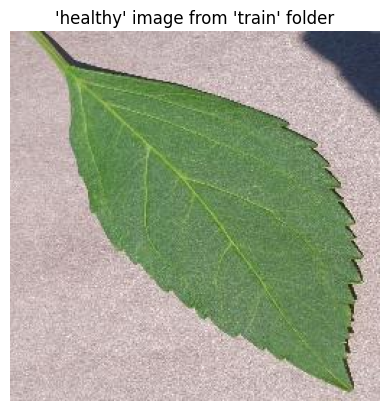

random train image: inputs\cherry-leaves\cherry-leaves\train\healthy\c36d1d7a-7e76-4be2-a637-e544f8210db8___JR_HL 9680_180deg.JPG


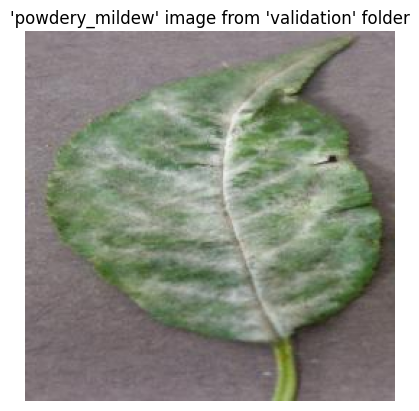

random validation image: inputs\cherry-leaves\cherry-leaves\validation\powdery_mildew\bd12f0aa-a242-420f-9811-dd75b1b5d6c0___FREC_Pwd.M 0456_flipLR.JPG


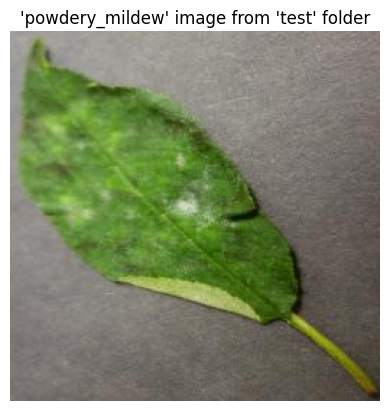

random test image: inputs\cherry-leaves\cherry-leaves\test\powdery_mildew\3494b335-17d6-437c-9bd2-cf43202f8576___FREC_Pwd.M 4903.JPG


In [6]:
from pathlib import Path

# Function to find and display a random image from subfolders
def show_random_image(parent_folder):
    """
    Selects and displays a random image from a subfolder inside the given parent directory.

    Args:
        parent_folder (str or Path): The path to the main dataset folder (e.g., train, validation, test).

    Returns:
        str or None: The full path to the randomly selected image, or None if no images are found.
    """

    parent_folder = Path(parent_folder)  # Ensure it's a Path object

    # Ensure the parent folder exists
    if not parent_folder.exists():
        print(f"path does not exist: {parent_folder}")
        return None

    # Scan subdirectories ('healthy', 'powdery_mildew')
    subfolders = [f for f in parent_folder.iterdir() if f.is_dir()]

    if not subfolders:
        print(f"no subfolders found in: {parent_folder}")
        return None

    # Pick a random subfolder (class name)
    chosen_folder = random.choice(subfolders)

    # Find image files inside that subfolder
    image_files = [f for f in chosen_folder.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}]

    if not image_files:
        print(f"no images found in: {chosen_folder}")
        return None

    # Select a random image and display it
    chosen_image = random.choice(image_files)

    # Load image using PIL
    image = Image.open(chosen_image)

    # Extract folder name ('healthy'/'powdery_mildew') and dataset section ('train'/'validation'/'test')
    class_name = chosen_folder.name
    dataset_section = parent_folder.name

    # Display the image with correct labeling
    plt.imshow(image)
    plt.title(f"'{class_name}' image from '{dataset_section}' folder")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

    return str(chosen_image)  # Return path for confirmation

# Fetch and display random images from each dataset section
train_image = show_random_image(train_path)
print(f"random train image: {train_image}")

val_image = show_random_image(val_path)
print(f"random validation image: {val_image}")

test_image = show_random_image(test_path)
print(f"random test image: {test_image}")

### Set Output Directory

Create 'output' directory if it doesn't already exist.

In [7]:
from pathlib import Path

# Define the root directory
root_dir = Path.cwd()  # Get current working directory
version = "v1"

# Construct the relative path for outputs
file_path = Path("outputs") / version

# Check if the directory for this version already exists
if file_path.exists():
    print(f'Old version "{version}" already exists and the file path to it has just been set.') 
    print(f'Create a new version if required. If not, you are good to go!')
else:
    try:
        # Create the directory if it doesn't exist
        file_path.mkdir(parents=True, exist_ok=True)
        print(f'Created new directory: {file_path}')
    except OSError as e:
        print(f'Error creating directory: {e}')

Old version "v1" already exists and the file path to it has just been set.
Create a new version if required. If not, you are good to go!


## Set the Label Names

Our upcoming binary classification task will require labeled data in order to train. Here we will set the labels to be used in our project:

- 'healthy'
- 'powdery_mildew'

In [8]:
# Set the labels
labels = os.listdir(train_path)
print('The labels for the images are', labels)

The labels for the images are ['healthy', 'powdery_mildew']


## Let's Count the Images

In the Data Collection notebook, we downloaded two directories of images:

- healthy
- powdery_mildew
  
We then split the images in each directory into three further folders:

- test
- train
- validation

In this notebook, we now need to count how many images are in each of these six folders. We will create a loop to do the count then display the results in a plot.

train - healthy: 1472 images
train - powdery_mildew: 1472 images
validation - healthy: 210 images
validation - powdery_mildew: 210 images
test - healthy: 422 images
test - powdery_mildew: 422 images


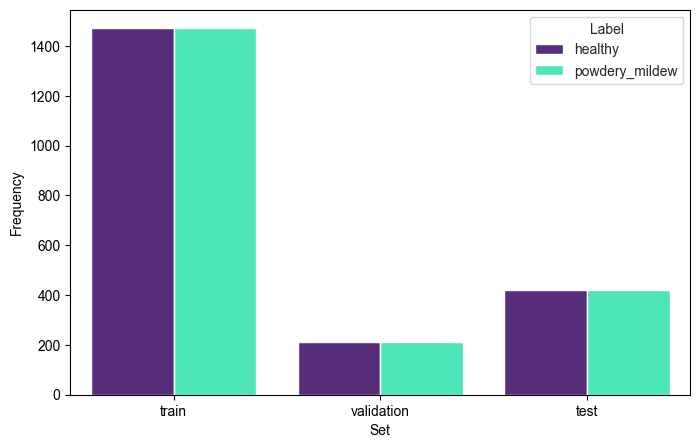

In [9]:
from pathlib import Path

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset partitions
folders = ['train', 'validation', 'test']

# Define root dataset directory
image_data = Path("inputs/cherry-leaves/cherry-leaves")
train_path = image_data / "train"
labels = [label.name for label in train_path.iterdir() if label.is_dir()]  # Extract directory names

# Collect data efficiently
for folder in folders:
    for label in labels:
        label_path = image_data / folder / label  # Use Path object
        num_images = len(list(label_path.glob("*"))) if label_path.exists() else 0  # Count files if path exists
        
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)

        print(f"{folder} - {label}: {num_images} images")

# Convert to DataFrame
df_freq = pd.DataFrame(data)

# Create the figure object
fig, ax = plt.subplots(figsize=(8, 5))

# Define custom colors
custom_colors = ["#582088", "#33FFC29F"]  # Adjust HEX colors as required

# Plot with updated colors
sns.set_style("whitegrid")
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_colors, ax=ax)

# Show plot (figure remains stored in 'fig' for later saving)
plt.show()

### Save the plot

If you're happy with the plot layout and colour scheme, save it in the 'outputs/v1' folder.

In [10]:
# Save the stored figure
fig.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
print("Plot saved successfully!")

Plot saved successfully!


As we can see from the count, we have equal numbers of 'healthy' and 'powdery_mildew' images across the train, test and validation folders. Had the numbers been unequal, we would have given consideration to data balancing (oversampling or undersampling). As it stands, we don't need to do any data balancing so we can now move on to data augmentation.

## Data Augmentation

Currently all our images look roughly the same in terms of size, aspect and zoom, for exmaple. To build a more robust machine learning model we need to 'rough up' our dataset a little. Real world images won't always look like the unifom set of images that we downloaded so we need the model to learn using an 'augmented' dataset. An augmented dataset introduces variations such as random rotations, cropping, zoom adjustments, brightness shifts, and flipping to simulate the unpredictability of real-world images.

This process helps the model to generalize better by learning from a diverse set of image transformations. By applying augmentation techniques, we can effectively enhance the robustness of our machine learning model, making it more resilient to variations in new and unseen data.

So, let's get to it!

### Import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image generator with normalization
image_gen = ImageDataGenerator(rescale=1./255)  # Normalizes pixel values

print("Image generator initialized.")

Image generator initialized.


Let's now define the adjustments that we want to make. Credit Code Institute WalkthroughProject01 for initial parameter selection.

In [13]:
augmented_image_data = ImageDataGenerator(
    rotation_range=25,  # More rotation to introduce stronger perspective shifts
    width_shift_range=0.15,  # Wider horizontal translations
    height_shift_range=0.15,  # Wider vertical translations
    shear_range=0.2,  # Stronger shearing for distortion effects
    zoom_range=0.2,  # More zoom variations to simulate different focal depths
    horizontal_flip=True,  # Mirroring images to improve orientation generalization
    vertical_flip=True,  # Vertical flips if objects don't depend on upright orientation
    brightness_range=(0.7, 1.3),  # Adjust brightness for lighting variations
    channel_shift_range=20,  # Shift pixel intensities for color variance
    fill_mode='nearest',  # Fill missing pixels using nearest neighbor interpolation
    rescale=1./255  # Normalization for pixel values
)

### Augmentation notes

We are going to be augmenting the image data in real-time, meaning that the images will be modified dynamically as they enter the model. This ensures that the model sees new variations of images in every epoch, helping it learn generalized patterns rather than memorizing specific features.

In the data visualization noteboook, we calculated the average image shape and stored that value in 'image_shape.pkl'. The model that we will be developing will need to know the dimensions of the images we will be training. To reduce the size of the .keras file that we will be generating, we will be defining a custom image shape in the cell block.

We may experiment with batch size as we fine-tune the model. Adjusting batch size impacts training speed and memory efficiency, so we may modify this value, if needed, to optimize performance.


### Define the image shape manually

In [14]:
# Define image shape manually
image_shape = (128, 128, 3)  # Example: (height, width, channels)

print(f"Using manually defined image shape: {image_shape}")

Using manually defined image shape: (128, 128, 3)


### Augment the train image data

In [15]:
from pathlib import Path

# Define batch size for training
batch_size = 8  # Balances memory efficiency & training speed

# Convert train_path to a Path object
train_path = Path("inputs/cherry-leaves/cherry-leaves/train")
if not train_path.exists():
    raise FileNotFoundError(f"Training directory {train_path} not found!")

# Extract width & height from stored image shape
target_size = tuple(image_shape[:2])

# Load training dataset with augmentation
train_set = augmented_image_data.flow_from_directory(
    train_path,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

# Check dataset summary
print(f"Using batch size: {batch_size}")
print(f"Found {train_set.samples} images belonging to {len(train_set.class_indices)} classes.")
print(f"Class mapping: {train_set.class_indices}")

# Load a sample batch to verify the image size
sample_images, _ = next(train_set)  # Fetch first batch
print(f"Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)


Found 2944 images belonging to 2 classes.
Using batch size: 8
Found 2944 images belonging to 2 classes.
Class mapping: {'healthy': 0, 'powdery_mildew': 1}
Sample image batch shape: (8, 128, 128, 3)


### Augment test image data

Now, when it comes to augmenting test image data, we are only going to worry about resizing the images. This is because the test images should be as close as possible to the 'real world' images that will be uploaded by the users.

As you can see from the variable below, we are only going to make use of the rescale parameter in the ImageDataGenerator class.

In [17]:
from pathlib import Path

# Extract width & height
target_size = tuple(image_shape[:2])

# Define the correct test path
test_path = Path("inputs/cherry-leaves/cherry-leaves/test")

# Validate path existence to prevent errors
if not test_path.exists():
    raise FileNotFoundError(f"Test directory {test_path} not found!")

# Load test dataset with augmentation
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    str(test_path),  # Ensure compatibility by converting Path to string
    target_size=target_size,
    color_mode="rgb",  # Loads images in RGB format
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False  # Keeps data order unchanged for consistent evaluation
)

# Check dataset summary
print(f"Using batch size: {batch_size}")  # Confirm batch size
print(f"Found {test_set.samples} images belonging to {len(test_set.class_indices)} classes.")
print(f"Class mapping: {test_set.class_indices}")

# Load a sample batch to verify image size
sample_images, _ = next(test_set)  # Fetch first batch
print(f"Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)

Found 844 images belonging to 2 classes.
Using batch size: 8
Found 844 images belonging to 2 classes.
Class mapping: {'healthy': 0, 'powdery_mildew': 1}
Sample image batch shape: (8, 128, 128, 3)


### Augment validation image data

The same logic applies to the validation image data. This should also match 'real world' data as closely as possible.

Notice that the basic code for augmenting the validation data is the same as that for the test data.

In [18]:
from pathlib import Path

# Extract width & height
target_size = tuple(image_shape[:2])

# Define the correct validation path
val_path = Path("inputs/cherry-leaves/cherry-leaves/validation")

# Validate path existence to prevent errors
if not val_path.exists():
    raise FileNotFoundError(f"Validation directory {val_path} not found!")

# Load validation dataset
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    str(val_path),  # Convert Path to string
    target_size=target_size,
    color_mode="rgb",  # Loads images in RGB format
    batch_size=batch_size,  # Define batch size
    class_mode="binary",
    shuffle=False  # Keeps data order unchanged to ensure consistent evaluation during validation
)

# Print dataset summary
print(f"Using batch size: {batch_size}")
print(f"Found {val_set.samples} images belonging to {len(val_set.class_indices)} classes.")
print(f"Class mapping: {val_set.class_indices}")

# Load a sample batch to verify image size
sample_images, _ = next(val_set)  # Fetch first batch
print(f"Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)

Found 420 images belonging to 2 classes.
Using batch size: 8
Found 420 images belonging to 2 classes.
Class mapping: {'healthy': 0, 'powdery_mildew': 1}
Sample image batch shape: (8, 128, 128, 3)


### Save class indices for later use

Let's now save the class indices into a .pkl file for later use. This will be required when deploying our model to ensure class labels remain consistent during inference (making predictions on unseen data).

In [19]:
from pathlib import Path

# Ensure file_path is a Path object
file_path = Path(file_path)

# Save class indices to a file using Pathlib
output_file = file_path / "class_indices.pkl"
joblib.dump(value=train_set.class_indices, filename=output_file)

print(f"File saved: '{output_file}'")

File saved: 'outputs\v1\class_indices.pkl'


### Let's take a look at some examples the augmented images

Before we start modelling, lets take a look at some samples of the augmented image data. The function below can be used to pull some random images from the directories.

In [20]:
def show_random_augmented_samples(train_set, val_set, test_set):
    """Displays three randomly selected augmented images from each dataset (train, validation, test) in a 3x3 plot."""
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    dataset_names = ["Train", "Validation", "Test"]
    datasets = [train_set, val_set, test_set]

    for col, (dataset_name, dataset) in enumerate(zip(dataset_names, datasets)):
        # Generate random indices for batch selection
        random_indices = np.random.randint(0, dataset.batch_size, 3)  

        for row, idx in enumerate(random_indices):  # Select images at random positions in batch
            img, label = next(dataset)  # Fetch a batch
            img = img[idx]  # Extract random image from batch
            
            axes[row, col].imshow(img)
            axes[row, col].axis("off")  # Hide axis for cleaner view
            if row == 0:  
                axes[row, col].set_title(dataset_name, fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

Now call the function...

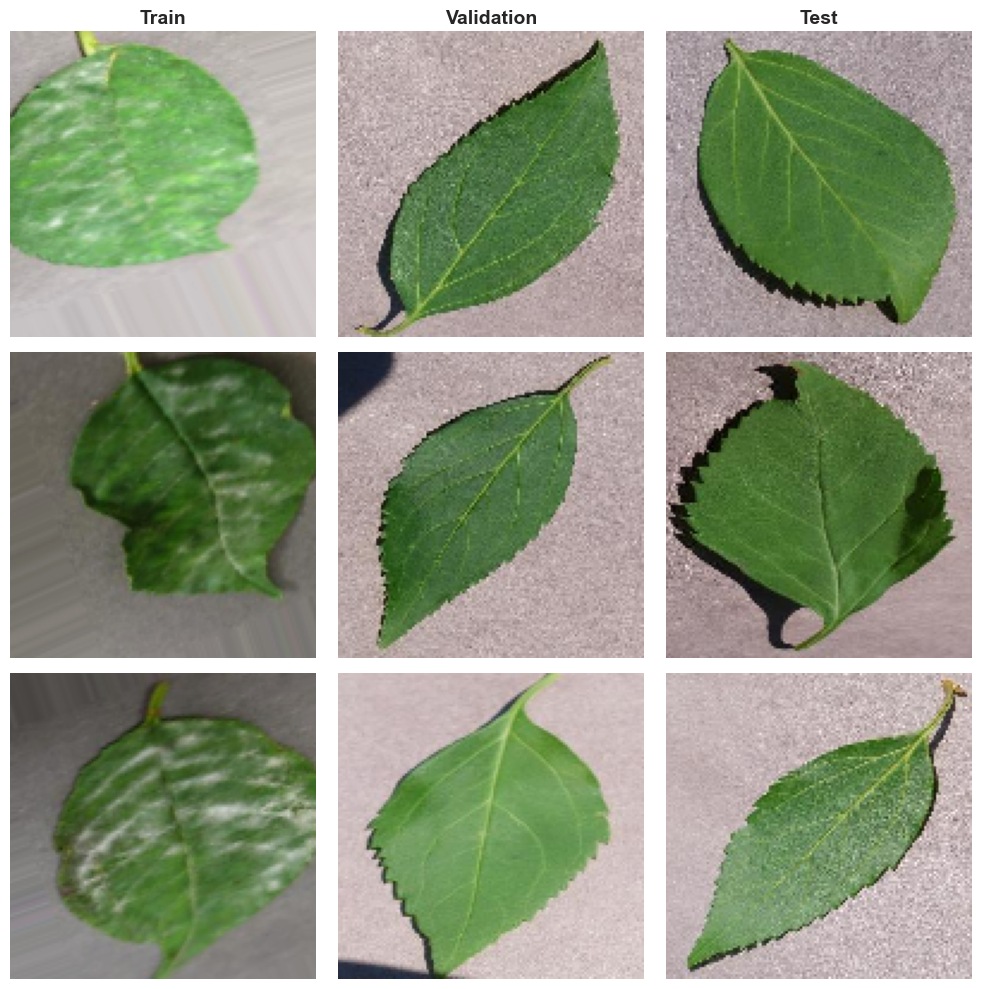

In [21]:
show_random_augmented_samples(train_set, val_set, test_set)

## The Model

Now we need to create a model that trains on our augmented dataset. This training will seek to identify patterns in the images and accurately classify cherry leaves as either healthy or affected by powdery mildew. 

This next step involves designing a deep learning model.


### Import the right tensor packages



In [22]:
import warnings
import tensorflow as tf
import sys
import re

# Suppress Keras warnings but keep them visible
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Suppress TensorFlow deprecation warnings properly
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Redirect standard error output to filter file paths while keeping warnings visible
class CleanLog:
    def write(self, message):
        # Mask file paths without removing the entire warning
        filtered_msg = re.sub(r"[A-Za-z]:\\\\(?:Users|AppData|Temp|.*?\\)", "[FILE PATH HIDDEN]\\", message)
        filtered_msg = re.sub(r"/(?:home|var|tmp|usr|.*?/)", "[FILE PATH HIDDEN]/", filtered_msg)  # UNIX Paths
        filtered_msg = re.sub(r"(ipykernel_\d+\\\d+\.py)", "[KERNEL FILE HIDDEN]", filtered_msg)  # Notebook-generated paths
        filtered_msg = re.sub(r"(ipykernel_\d+/\d+\.py)", "[KERNEL FILE HIDDEN]", filtered_msg)  # Alternative Jupyter formats

        sys.__stderr__.write(filtered_msg)  # Print filtered warnings to console

    def flush(self):
        sys.__stderr__.flush()

sys.stderr = CleanLog()

# Confirm TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.16.1


In [23]:
# Import TensorFlow components for model training
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers


print("TensorFlow methods imported successfully.")

TensorFlow methods imported successfully.


### Define the model

Credit Code Institite WalkthoughProject01 for the initial model structure.  

In [ ]:

def create_tf_model(input_shape=image_shape):
    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))  
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))  
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))  
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    # L2 added to help prevent overfitting by penalizing large weight values
    # Added in response to validation accuracy issues in previous model iterations
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005)))  
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer (no L2 needed)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

#### Create a model summary

We do this so that we can visually inspect the model architecture, verify layer configurations, check input/output shapes, and ensure the number of trainable parameters aligns with our expectations before training begins.


In [25]:
create_tf_model().summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Early stopping

As the model learns it should get more accutrate over the epochs. At some point, the learning will slow and imporvements will become minimal. Once this begins to happen, we can stop the training early to help prevent overfitting, ensuring the model does not memorize the training data but generalizes well on unseen data.

The varibale below can be used to stop the training when after 3 epochs (patience=3), value loss stops improving (monitor='val_loss'). This variable will also restore the weights from the best performing epoch (restore_best_weights=True) which will then become the inference model used by the client.

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Before fitting the model, lets just check how the training data is broken down.

In [27]:
print(f"Total training images: {train_set.samples}")  
print(f"Batch size: {batch_size}")  
print(f"Calculated steps_per_epoch: {train_set.samples // batch_size}")  

Total training images: 2944
Batch size: 8
Calculated steps_per_epoch: 368


In [26]:
# fit model for training

# Create the model
model = create_tf_model()

# Train the model
steps_per_epoch = train_set.samples // batch_size

model.fit(train_set,
              epochs=25,
              steps_per_epoch=steps_per_epoch,  
              validation_data=val_set,
              callbacks=[early_stop],
              verbose=1)

Epoch 1/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - accuracy: 0.7486 - loss: 0.5363 - val_accuracy: 0.9881 - val_loss: 0.1083
Epoch 2/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9358 - loss: 0.2481 - val_accuracy: 0.9857 - val_loss: 0.1441
Epoch 3/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9647 - loss: 0.1681 - val_accuracy: 0.9952 - val_loss: 0.0825
Epoch 4/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9747 - loss: 0.1350 - val_accuracy: 0.9881 - val_loss: 0.0992
Epoch 5/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9738 - loss: 0.1334 - val_accuracy: 0.9952 - val_loss: 0.0760
Epoch 6/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9886 - loss: 0.1056 - val_accuracy: 0.9905 - val_loss: 0.0820
Epoch 7/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9807 - loss: 0.1204 - val_accuracy: 0.9929 - val_loss: 0.0881
Epoch 8/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9825 - loss: 0.1086 - 

#### Save model

Now we save the model with the best weights to a .keras file.

In [51]:
save_path = "outputs/v1/mildew_detector_model.keras"
model.save(save_path)

# Get file size in MB
file_size_mb = os.path.getsize(save_path) / (1024 * 1024)

print(f"File saved: '{save_path}' | Size: {file_size_mb:.2f} MB")

File saved: 'outputs/v1/mildew_detector_model.keras' | Size: 37.87 MB


#### Model performance

Now that the model has been fitted, we need to assess its performance. The code below will generate a couple of plots to show the training loss compared to the validation loss, and the training accuracy compared to the validation accuracy.

In [ ]:
# Define custom colours to apply to the plots
custom_colors = ["#582088", "#33FFC29F"]

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")

# Loss plot
losses[['loss', 'val_loss']].plot(style='.-', color=custom_colors)
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

# Accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', color=custom_colors)
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

The following code will display the saved polts so we can see the performance - use this code block if you don't want to re-run the model but have access to the saved plots in outputs/v1.

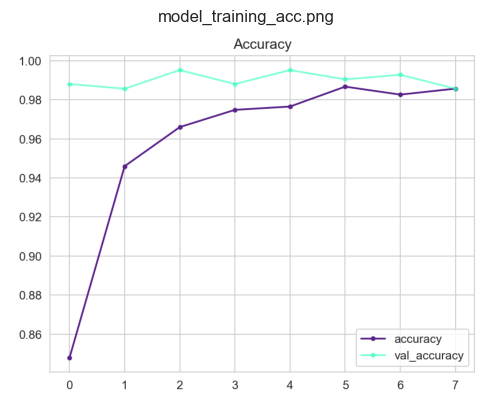

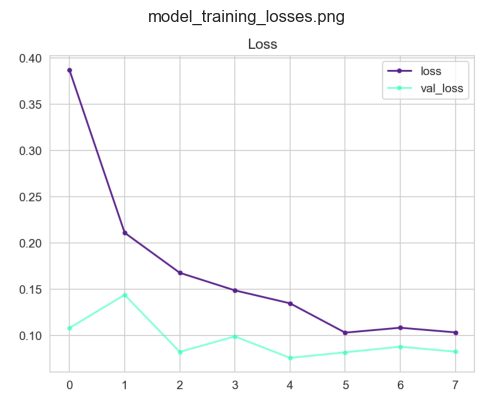

In [55]:
import matplotlib.pyplot as plt
from pathlib import Path

# Define the output folder
output_dir = Path("outputs/v1")  # Adjust if needed

# List of saved plots
plot_files = ["model_training_acc.png", "model_training_losses.png"]

# Display each plot
for plot_file in plot_files:
    plot_path = output_dir / plot_file  # Construct the full path
    if plot_path.exists():
        img = plt.imread(plot_path)
        plt.imshow(img)
        plt.axis("off")
        plt.title(plot_file)
        plt.show()
    else:
        print(f"File not found: {plot_path}")

#### Performance summary

The above plots show that validation accuracy started high and remained high across all epochs. It stayed consistently above training accuracy, which started low but jumped quickly above 94% and peaked at 98.86% in epoch 6. This suggests rapid learning early in the training. While validation accuracy remained stable, there were slight fluctuations in later epochs that might warrant further investigation.

Similarly, the loss values for the training data show rapid declines as the epochs progressed. Validation loss peaked in the second epoch at 0.1441, then dropped and mostly stayed below 0.1, with slight fluctuations. This suggests confident generalization. As validation losses plateaued, it is likely that training stopped early due to patience becoming exhausted - early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True).

These results suggest that this model is high performing, learns quickly and maintains excellent validation accuracy. Although there are some slight variations in validation loss, the model seems to generalise well 


### Model evaluation

Run the following code cell to evaluate the fitted model using the test set imahe data.

In [41]:

evaluation = model.evaluate(test_set)

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9965 - loss: 0.0909


Now save the evaluation in a .pkl file for later use.

In [42]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

#### Predict on new data

The code block below will select and load an image from the test set to be used by the model to infer classification.

If you want to change the image, adjust the 'pointer' value. If you want test on a different category, adjust the 'label' value.

Image Path: inputs\cherry-leaves\cherry-leaves\test\powdery_mildew\1bbbffe8-ebdd-497c-b8ed-d90ad1a901e8___FREC_Pwd.M 4755.JPG
Image Shape: (128, 128), Image Mode: RGB


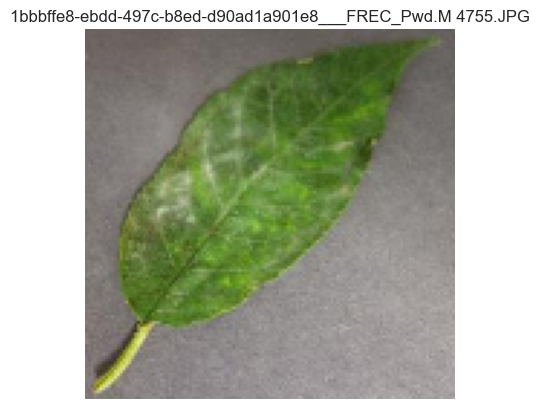

In [47]:
from pathlib import Path
from tensorflow.keras.preprocessing import image

# Define pointer & label - adjust pointer number to see different test images
pointer = 42 
label = labels[1]  # Select "healthy" - [0] or "mildewed" - [1] 

# Get image directory and file list  
image_dir = Path(test_path) / label  
image_files = list(image_dir.iterdir())  

# Ensure pointer is within range  
if pointer >= len(image_files):  
    raise IndexError(f"Pointer index {pointer} exceeds available images ({len(image_files)}).")  

# Load image  
image_path = image_files[pointer]  
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')  

# Display image details  
print(f"Image Path: {image_path}")  
print(f"Image Shape: {pil_image.size}, Image Mode: {pil_image.mode}")  

# Show image  
plt.imshow(pil_image)  
plt.axis("off")  
plt.title(image_path.name)  
plt.show()

Now prepare the image for inference.

In [59]:
# Convert the PIL image to a NumPy array
my_image = image.img_to_array(pil_image)  # Converts RGB image into numerical array format

# Expand dimensions to match the expected input shape for the model
my_image = np.expand_dims(my_image, axis=0)  # Adds a batch dimension (for single image inference)

# Normalize pixel values to range [0,1] for better model performance
my_image = my_image / 255.0  # Standard normalization for neural network input

# Print the shape to verify transformation
print(f"Processed Image Shape: {my_image.shape}")
print(f"Training Image Shape: {image_shape}")
print(f"The processed image shape should be the same as the training image shape.")
print(f"Don't worry abou the first number in processed image shape, that just the batch size for this test.")

Processed Image Shape: (1, 128, 128, 3)
Training Image Shape: (128, 128, 3)
The processed image shape should be the same as the training image shape.
Don't worry abou the first number in processed image shape, that just the batch size for this test.


#### Inference

Run the following cell to predict the classification of the test image and see the model's confidence in that prediction. This code takes the numeric probability and turns it into a binary classification.

In [ ]:
# Predict probability  
pred_proba = model.predict(my_image)[0, 0]  

# Map numerical predcitions to 'healthy' or 'powdery_mildew'
target_map = {v: k for k, v in train_set.class_indices.items()}  

# Determine predicted class - apply explicit type conversion at a 50% threshold
pred_class = target_map[int(pred_proba > 0.5)]  

# Adjust probability for binary classification  
pred_proba = np.abs(pred_proba - (pred_class == target_map[0]))

# Print results  
print(f"Predicted Class: {pred_class}")  
print(f"Confidence: {pred_proba:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Class: powdery_mildew
Confidence: 0.9998


#### Evaluation summary

The model was evaluated using a set of unseen test data, split into 106 batches.

The evaluation returned an accuracy of 0.9965 and a loss of 0.0909. Both metrics are in line with the validation figures observed during model fitting.

Additionally, the model correctly identified an image of powdery mildew with a confidence level of 0.9998.

Taken together, these results provide strong evidence that the model is highly accurate and reliable in detecting powdery mildew in cherry leaves. The model exceeds the client's requirement of 97% accuracy and is well-suited for deployment.
